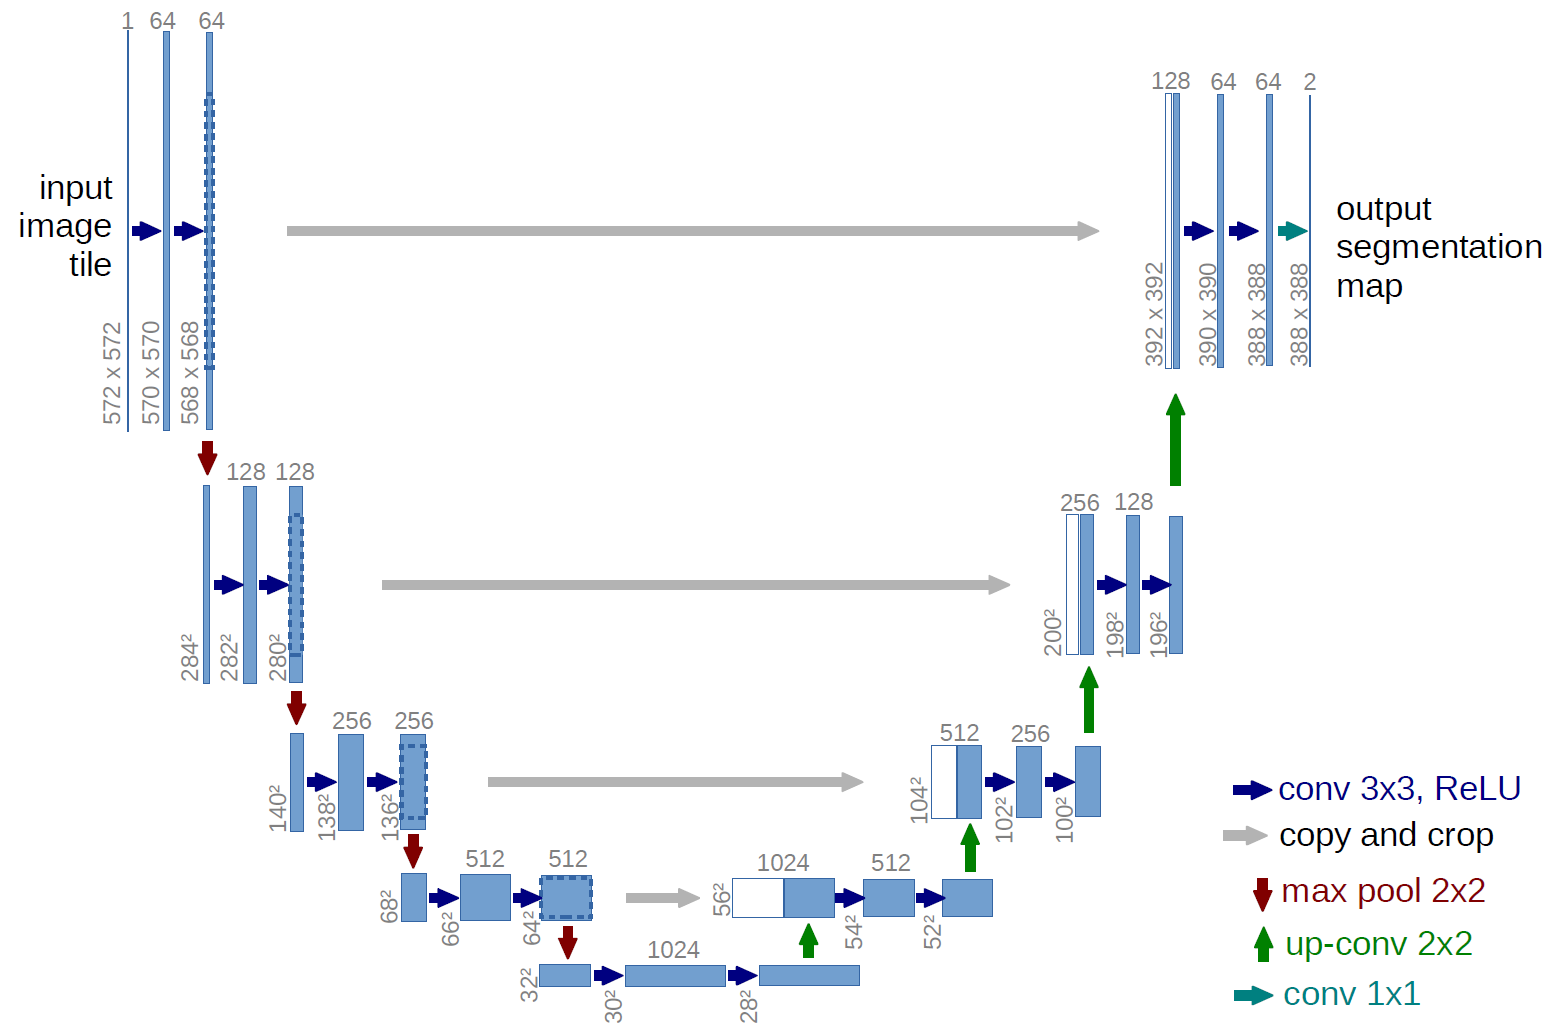

## Условие

Нужно реализовать `U-Net` в файле `model.py` для задачи семантической сегментации: `0` - не автомобиль, `1` - автомобиль.  Назовите класс с моделью `SegmenterModel`, унаследуйте его от `torch.nn.Module`, напишите метод `forward`. Ваша модель должна принимать четырёхмерные тензоры картинок (нулевая размерность — батч) и предсказывать трёхмерные тензоры (нулевая размерность — батч) из логарифмов вероятностей (логитов) каждого пикселя в бернуллиевской модели. В качестве функции ошибки при обучении используется **бинарная кросс-энтропия** в реализации с логитами — `torch.nn.BCEWithLogitsLoss()`. Переход от логитов к маске осуществляется посредством отсечения по порогу: `logits > 0`.

Нужно добиться среднего значения метрики `IoU` по тестовой выборке:
- **на зачёт** — хотя бы в `0.6`; 
- **на бонусные баллы** — хотя бы в `0.8` (авторское решение даёт `0.95`).  

Обучение модели, а также оценка её качества уже реализованы за вас. Ваша реализация должна быть согласована с уже написанным кодом (любая разумная реализация удовлетворяет этим требованиям; если вы уверены, что это не так, то напишите в чат курса).

Данные — подмножество датасета [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) с Kaggle.  

**Рекомендации:**
- Используйте `Google Colab`. Загрузите туда `data.zip` (довольно долго), `carvana_dataset.py` и `train.py`. Эти файлы заранее скачайте себе на папку в GDrive, потом примонтируйте диск к `Colab` и выкачайте архив с данными оттуда. **Важно:** сначала выберите рантайм с `GPU`, а потом уже загружайте файлы! Файлы нужно именно загрузить, т.к. иначе работать будет слишком медленно (придётся при обучении каждый раз читать файлы по сети);
- Обучайте модель достаточно долго. Несколько десятков эпох это норма. 
- Прекращайте обучение только тогда, когда лосс на тестовой выборке перестаёт падать;
- Для визуализации процесса обучения используйте `tensorboard`. Он уже интегрирован в `training loop` для вас. Запустить его можно и на своей машине: просто скачайте папку `log` с Colab и введите в терминале `tensorboard --log_dir /path/to/log`

## Загрузка файлов и данных на Colab

Заранее сделайте папку на своём `GDrive`, потом примонтируйте её и скачайте оттуда все файлы.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/segmentation_hw/* .

Mounted at /content/drive


Распакуем данные на инстансе

In [ ]:
!sudo apt install pv
!unzip data.zip | pv -l >/dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  doc-base
The following NEW packages will be installed:
  pv
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 48.3 kB of archives.
After this operation, 123 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 pv amd64 1.6.6-1 [48.3 kB]
Fetched 48.3 kB in 1s (32.2 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package pv.
(Reading database ... 144439 files and directo

## Подключаем TensorBoard

Это нужно сделать до запуска скрипта с обучением.  Этот виджет интерактивный.  
Он автоматически обновляется по мере обучения модели

In [ ]:
!pip install tensorboardx
!mkdir log
%load_ext tensorboard
%tensorboard --logdir ./log

mkdir: cannot create directory ‘log’: File exists
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

## Обучение модели

Для вашего удобства, обучение и валидация модели вынесены в отдельный файл `train.py`.  
При условии, что вы правильно реализовали модель, для начала обучения достаточно запустить ячейку ниже.  

На каждой итерации обученная модель сохраняется на диск в виде файла `unet_dump_recent`. Используйте это для отладки.  
Каждый дамп довольно объёмный — порядка 120 мб. для авторской модели, — но если вы хотите сохранять модель на диск по какой-то другой логике, то поправьте соответствующие строки в файле `train.py`.

In [ ]:
!python train.py --n_epochs 35 --batch_size 10 --learning_rate 0.01

## Визуализация результатов

Импортируйте нужные библиотеки и отрисуйте предсказания модели на нескольких случайных объектах из тестовой выборки.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.utils.data as dt
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from model import SegmenterModel
from carvana_dataset import CarvanaDataset

%matplotlib inline

Датасет преобразуется в формат, совместимый с `torch.utils.data.DataLoader` посредством класса `CarvanaDataset`.  
**Не меняйте его**, примеры использования для своих нужд вы можете найти ниже:

In [ ]:
train_data = CarvanaDataset('./train/', './train_masks/')
test_data = CarvanaDataset('./test/', './test_masks/')

Подгрузим предобученную модель. Если вы изменили логику сохранения копий модели на диск, отразите эти изменения и здесь тоже.

In [ ]:
unet = SegmenterModel().cuda()
unet.load_state_dict(torch.load("unet_dump_recent", map_location="cuda:0"))
unet.train(False);

Код для отрисовки предсказаний модели на одной картинке

In [ ]:
def plot_predictions_on_random_image(fitted_model: SegmenterModel, 
                                     test_data: CarvanaDataset, 
                                     seed: int = None):
    if seed is None:
        rvgen = np.random
    else:
        rvgen = np.RandomState(seed)
        
    n_img = len(test_data.files)
    img_idx = rvgen.randint(0, n_img)
    img = test_data[img_idx][0]
    true_mask = test_data[img_idx][1].squeeze(0)
    
    pred_logits = fitted_model.forward(img.unsqueeze(0).cuda())
    pred_logits = pred_logits\
                    .squeeze(0).squeeze(0)\
                    .detach().cpu().numpy()
    pred_mask = pred_logits > 0
    
    images_to_plot = [img.permute(1, 2, 0), true_mask, pred_mask, pred_logits]
    ax_titles = ["Оригинал", 
                 "Истинная маска",
                 "Предсказанная маска (порог — 0)", 
                 "Предсказанные логиты"]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    for i in range(len(axes)):
        ax = axes[i]
        ax.imshow(images_to_plot[i], cmap="inferno")
        ax.set_title(ax_titles[i], fontsize=15, fontweight="bold")
        ax.set_axis_off()

Сравним предсказанные маски с истинными 

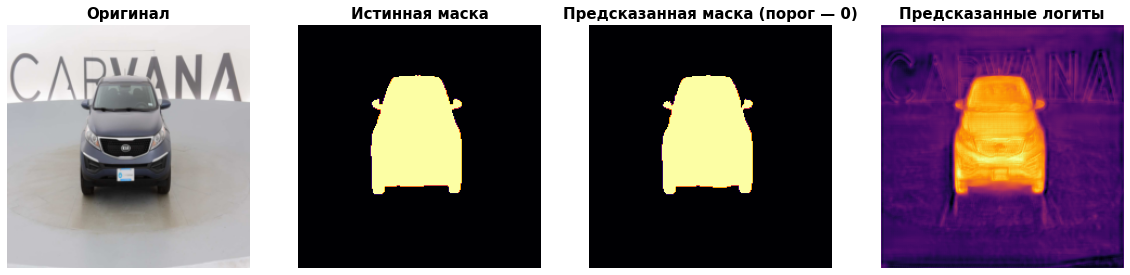

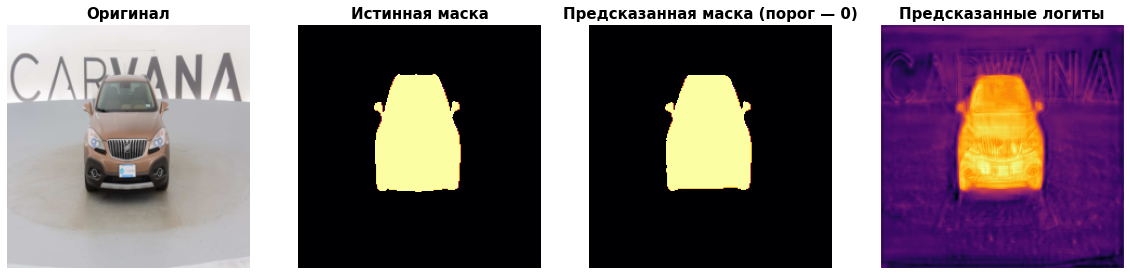

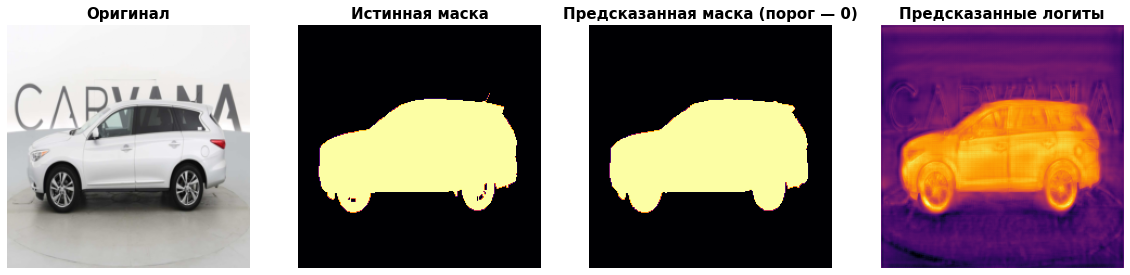

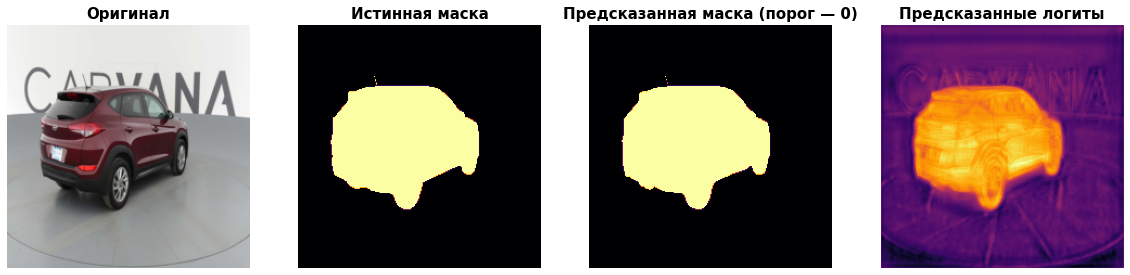

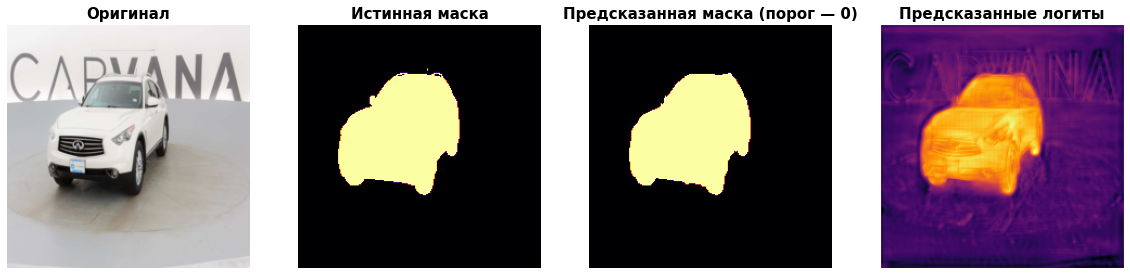

In [ ]:
for i in range(5): 
    plot_predictions_on_random_image(unet, test_data)

## Оценка качества модели

В задаче семантической сегментации уместно использовать метрику `IoU` — *Intersection over Union* — которая равняется доле корректно предсказанных пикселей маски среди всех пикселей, которые либо модель, либо разметка считают пикселями маски

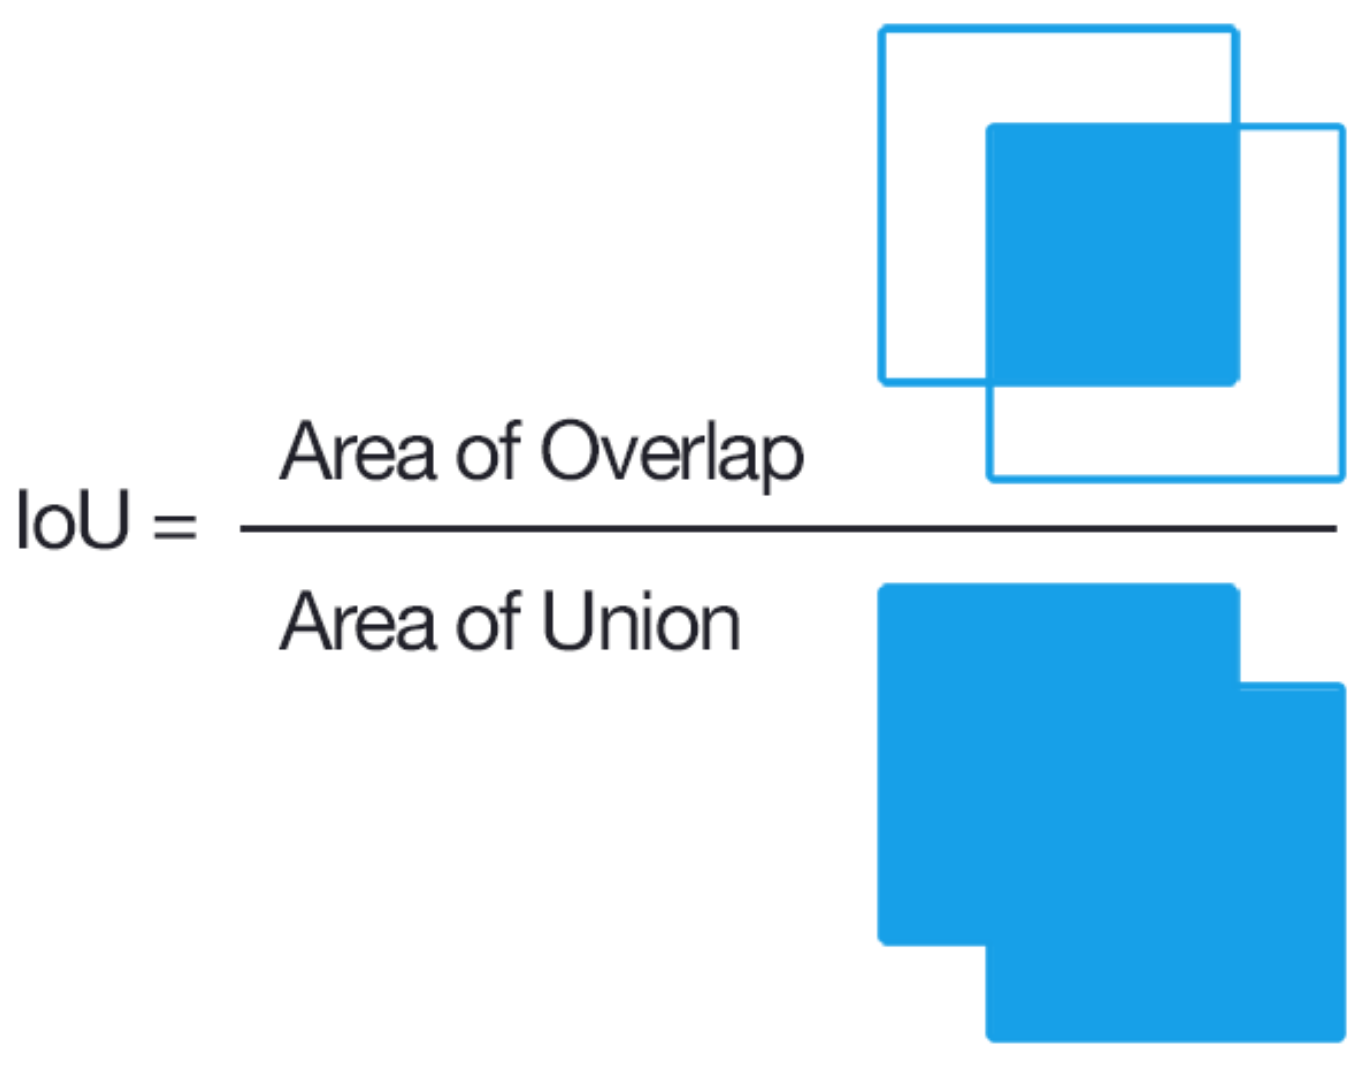

In [ ]:
def iou_loss(predicted_mask_batch, target_mask_batch):
    """ Считает IoU по всем элементам батча """
    
    intersection = predicted_mask_batch & target_mask_batch
    union = predicted_mask_batch | target_mask_batch
    # batch-размерность не трогаем
    loss = intersection.double().sum((1, 2, 3)) \
            / union.double().sum((1, 2, 3))
    return loss

Среднее значение IoU на тестовой выбрке: 0.63589456


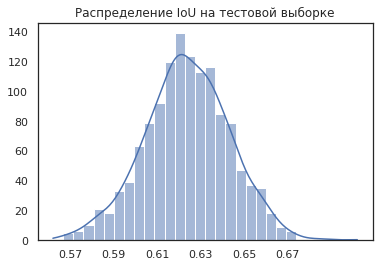

In [ ]:
dl_test = dt.DataLoader(test_data, shuffle=False, 
                        num_workers=8,
                        batch_size=1)

    
test_loss = []
for i, (input_batch, target_mask_batch) in enumerate(tqdm(dl_test)):
    with torch.no_grad():
        output_logits_batch = unet(input_batch.to("cuda")).cpu()
    output_mask_batch = output_logits_batch > 0
    loss = iou_loss(output_mask_batch, target_mask_batch > 0)
    test_loss.append(loss.numpy())
test_loss = np.hstack(test_loss)

print(f"Среднее значение IoU на тестовой выбрке: {np.mean(test_loss)}")
plt.title("Распределение IoU на тестовой выборке")
sns.distplot(test_loss);

Пороги по `IoU` смотрите в самом начале задания

## Бонусная  часть
Попробуйте побить `baseline` в виде авторского решения:
1. Сделайте аугментацию данных;
2. Подберите оптимальную архитектуру (может отличаться от рекомендованной);
3. Обратитесь к литературе за сведениями о том, как делают fine-tuning для `U-Net`;